<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/imgcap_attend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Fri Jun  4 09:03:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json,re,pickle
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping,History
from keras.models import Model,load_model
#from keras.utils import plot_model
from keras.layers import LSTM,TimeDistributed,Dense,Embedding,Input,Flatten,Multiply,Dropout,Concatenate,Reshape,AdditiveAttention,Attention
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from keras.activations import tanh,softmax
from PIL import Image 
from tqdm import tqdm

In [ ]:
img_path = '/content/drive/MyDrive/MSCOCO_2017/val2017'
anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_train2017.json'

# caption 處理

In [ ]:
def preprocess(text):
  text = text.lower()
  tmp = re.split('\W+',text)
  return tmp

In [ ]:
start= "<sos>"
end = "<end>"
pad = "<pad>"

In [ ]:
input_file = open(anno_path)
annotation = json.load(input_file)
max_length = 30
top_word = 5
tmp = ""
sentence = []
for x in tqdm(annotation['annotations']):
  tmp = preprocess(x['caption'])
  tmp = " ".join(tmp)
  x['caption'] = start + " " + tmp + " " + end
  sentence.append(x['caption'])
#print(sentence[:50])
# filters default without '<' '>' because <start> and <end>
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='<unk>')
token.fit_on_texts(sentence)
ind = 2
wc = token.word_counts
word_index = {}
word_index['<unk>'] = 1
for i in wc:
  if (int)(wc[i]) >= (int)(top_word):
    word_index[i] = ind
    ind += 1
word_index['<pad>'] = 0
inv_word_index = {v: k for k, v in word_index.items()}
voc_size = len(word_index) + 1

100%|██████████| 591753/591753 [00:02<00:00, 218328.77it/s]


In [ ]:
print(token.word_counts)
print(len(token.word_counts))
print(word_index)
print(inv_word_index)
print(len(word_index))
print(max_length)
print(voc_size)

OrderedDict([('<sos>', 591753), ('a', 978680), ('bicycle', 2295), ('replica', 40), ('with', 154811), ('clock', 10565), ('as', 7663), ('the', 197770), ('front', 19516), ('wheel', 396), ('<end>', 591753), ('room', 18321), ('blue', 13795), ('walls', 1418), ('and', 140916), ('white', 36364), ('sink', 8032), ('door', 2911), ('car', 7107), ('that', 28175), ('seems', 237), ('to', 68161), ('be', 2444), ('parked', 12544), ('illegally', 6), ('behind', 6661), ('legally', 4), ('large', 24556), ('passenger', 2172), ('airplane', 5129), ('flying', 10159), ('through', 8612), ('air', 7590), ('there', 12866), ('is', 98184), ('gol', 1), ('plane', 4810), ('taking', 3888), ('off', 4273), ('in', 184142), ('partly', 114), ('cloudy', 1572), ('sky', 6111), ('color', 420), ('scheme', 23), ('small', 20094), ('bathroom', 14444), ('this', 6745), ('wall', 7025), ('lifesaver', 1), ('on', 215689), ('boat', 5594), ('themed', 154), ('life', 308), ('preserver', 8), ('bike', 3840), ('has', 15116), ('tire', 178), ('two', 

# Encoder model

In [ ]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('block5_conv3')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

In [ ]:
# Provide by @snsd0805
def preprocess_img(path):
  img = image.load_img(path, target_size=(224, 224))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = encoder_model.predict(x)
  return features

#GloVe


In [ ]:
f = open('/content/drive/MyDrive/MSCOCO_2017/GloVe.6B/glove.6B.100d.txt',encoding="utf-8")
embedded_vector_index = {}
for i in f:
  values = i.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedded_vector_index[word] = coefs
#print(f'Found {len(embedded_vector_index)} word vectors.') #Found 400000 word vectors

In [ ]:
embedded_matrix = np.zeros((voc_size,100))
n = 0
for word, i in word_index.items():
    embedding_vector = embedded_vector_index.get(word)
    if embedding_vector is not None: #不能map到的word為0向量
      embedded_matrix[i] = embedding_vector
      n += 1
embedded_matrix[word_index['<sos>']] = np.random.randn(100) #特殊token為100維的隨機向量
embedded_matrix[word_index['<pad>']] = np.random.randn(100)
embedded_matrix[word_index['<end>']] = np.random.randn(100)
#avg_vec = np.mean(embedded_matrix,axis=0) #用有用到的word vector取平均作為unk的word vector
embedded_matrix[word_index['<unk>']] = np.random.randn(100)

#Decoder model

In [ ]:
concate_1 = Concatenate(axis=-1,name='feature_hidden')
concate_2 = Concatenate(axis=1,name='hidden_196')
hidden = Input(shape=(512),name='hid')
feature = Input(shape=(196,512),name='img_feature')
ex_hidden = tf.expand_dims(hidden,1)
new_hidden = ex_hidden
for i in range(195):
    new_hidden = concate_2([new_hidden,ex_hidden])
tmp_in = concate_1([feature,new_hidden])
score = TimeDistributed(Dense(1))(tmp_in)
score = tf.reduce_sum(score,-1)
distribute = Dense(196,activation='softmax',name='distribution')(score)
out = tf.expand_dims(distribute,-1) * feature
attention = Model(inputs=[hidden,feature],outputs=out,name='Attention_Model')
attention.summary()

Model: "Attention_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hid (InputLayer)                [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 512)       0           hid[0][0]                        
__________________________________________________________________________________________________
hidden_196 (Concatenate)        multiple             0           tf.expand_dims[0][0]             
                                                                 tf.expand_dims[0][0]             
                                                                 hidden_196[0][0]                 
                                                                 tf.expand_dims[0][0

In [ ]:
in_img = Input(shape=(196,512),name='feature')
in_text = Input(shape=(1,100,),name='word')
in_h = Input(shape=(512),name='hidden')
in_c = Input(shape=(512),name='cell')
att = attention([in_h,in_img])
x = tf.reduce_mean(att,axis=-1)
concat = Concatenate(name='concate')([tf.expand_dims(x,1),in_text])
out,out_h,out_c = LSTM(512,return_sequences=True,return_state=True,name='LSTM')(concat,initial_state=[in_h,in_c])
lm = Model(inputs=[in_img,in_text,in_h,in_c],outputs=[out,out_h,out_c],name='Language_Model')
lm.summary()

Model: "Language_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hidden (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
feature (InputLayer)            [(None, 196, 512)]   0                                            
__________________________________________________________________________________________________
Attention_Model (Functional)    (None, 196, 512)     39637       hidden[0][0]                     
                                                                 feature[0][0]                    
__________________________________________________________________________________________________
tf.math.reduce_mean (TFOpLambda (None, 196)          0           Attention_Model[0][0

In [ ]:
inputs1 = Input(shape=(14,14,512),name='feature')
r1 = Reshape((196,512))(inputs1)
m = tf.reduce_mean(r1,axis=-1)
h = Dense(512,name='ini_hidden_state')(m)
c = Dense(512,name='ini_cell_state')(m)
inputs2 = Input(shape=(30,),name='text')
concate_time = Concatenate(axis=1,name='concate_time')
emb = Embedding(voc_size, 100, mask_zero=True,name='Embedding_layer')(inputs2)
for i in range(30):
  out,h,c = lm([r1,tf.expand_dims(emb[:,i],1),h,c])
  ex_out = tf.expand_dims(out,1)
  if i == 0:
    tmp_out = ex_out
  else:
    tmp_out = concate_time([tmp_out,ex_out])
pred = tf.reduce_sum(tmp_out,axis=-2)
drop = TimeDistributed(Dropout(0.5))(pred)
decode1 = TimeDistributed(Dense(voc_size, activation='softmax',name='output_Layer'))(drop)

model = Model(inputs=[inputs1, inputs2], outputs=[decode1],name='imgcap_model')
# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])

model.get_layer("Embedding_layer").set_weights([embedded_matrix])
model.get_layer("Embedding_layer").trainable = False
# summarize model
model.summary()
#plot_model(model, to_file='model_1.png', show_shapes=True)

Model: "imgcap_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature (InputLayer)            [(None, 14, 14, 512) 0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 30)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 196, 512)     0           feature[0][0]                    
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 30, 100)      1019300     text[0][0]                       
_______________________________________________________________________________________

In [ ]:
#Load data
p = open('/content/drive/MyDrive/MSCOCO_2017/new-dataset/output_14x14x512_train5000.pkl', 'rb')
train_data = pickle.load(p)
p = open('/content/drive/MyDrive/MSCOCO_2017/new-dataset/output_14x14x512_5000_val.pkl', 'rb')
val_data = pickle.load(p)

In [ ]:
def data_generator(input_data):
  x1, x2, y = [], [], []
  for data in tqdm(input_data):
    for cap in data['captions']:  
      tmp = preprocess(cap) # 和前面一樣，刪掉標點符號
      #下面迴圈是把不在VOC的詞替換成<unk>
      for i in range(len(tmp)):
        if word_index.get(tmp[i]) == None:
          tmp[i] = "<unk>"  
      tmp = " ".join(tmp)
      tmp = start + " " + tmp + " " + end 
      seq = [word_index[word] for word in tmp.split(' ') if word in word_index]  #做斷詞並將詞轉成label    
      in_seq, out_seq = seq[:-1], seq[1:] #ex. in_seq = [1,2,3,4,5] out_seq = [2,3,4,5]
      #做padding將句子用0補在後面補到max_length
      in_seq = pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
      out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')[0]
      x1.append(data['feature'][0])
      x2.append(in_seq)
      y.append(out_seq)
  return ([np.array(x1), np.array(x2)], np.array(y)) 

In [ ]:
print(len(train_data[0]['feature']))

1


In [ ]:
trainx, trainy = data_generator(train_data)

100%|██████████| 5000/5000 [00:01<00:00, 3064.58it/s]


In [ ]:
valx, valy = data_generator(val_data[3000:])

100%|██████████| 2000/2000 [00:00<00:00, 3381.38it/s]


In [ ]:
my_callbacks = [EarlyStopping(patience=5,monitor='val_loss')]
result = model.fit(trainx,trainy,epochs=20,callbacks=my_callbacks,validation_data=(valx,valy))

Epoch 1/20
782/782 [==============================] - 866s 607ms/step - loss: 2.2431 - sparse_categorical_accuracy: 0.6838 - val_loss: 1.5224 - val_sparse_categorical_accuracy: 0.7388
Epoch 2/20
782/782 [==============================] - 329s 421ms/step - loss: 1.4780 - sparse_categorical_accuracy: 0.7413 - val_loss: 1.3728 - val_sparse_categorical_accuracy: 0.7526
Epoch 3/20
782/782 [==============================] - 330s 422ms/step - loss: 1.3323 - sparse_categorical_accuracy: 0.7522 - val_loss: 1.3087 - val_sparse_categorical_accuracy: 0.7580
Epoch 4/20
782/782 [==============================] - 329s 421ms/step - loss: 1.2598 - sparse_categorical_accuracy: 0.7584 - val_loss: 1.2755 - val_sparse_categorical_accuracy: 0.7619
Epoch 5/20
782/782 [==============================] - 330s 422ms/step - loss: 1.1994 - sparse_categorical_accuracy: 0.7626 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.7646
Epoch 6/20
782/782 [==============================] - 329s 421ms/step - loss: 1.

In [ ]:
model.save('/content/drive/MyDrive/MSCOCO_2017/model_att_train5000_4.h5')

In [ ]:
def Generate_caption(img_path,show=True):
  decoder_model = model
  img_data = preprocess_img(img_path)
  decoder_input = np.zeros((1,max_length),dtype='float32')
  token_cur = word_index[start]
  output_text = ''
  count_tokens = 0
  while token_cur != word_index[end] and count_tokens < max_length:
    decoder_input[0,count_tokens] = token_cur
    #print(decoder_input)
    decoder_output = decoder_model.predict([img_data,decoder_input])
    token_cur = np.argmax(decoder_output[0,count_tokens]) 
    #print(token_cur)
    cur_word = inv_word_index[token_cur]
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

In [ ]:
Generate_caption('/content/drive/MyDrive/cat2.jpg')
Generate_caption('/content/drive/MyDrive/seal.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/test2017/000000000155.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/test2017/000000001371.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')

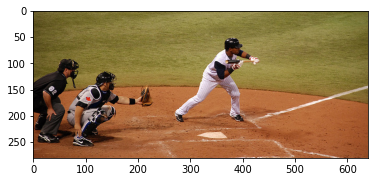

Caption:
 a baseball player swinging a bat at a ball <unk>


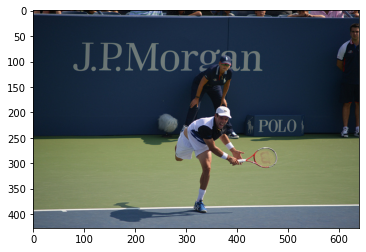

Caption:
 a tennis player is swinging a racket at a ball <unk>


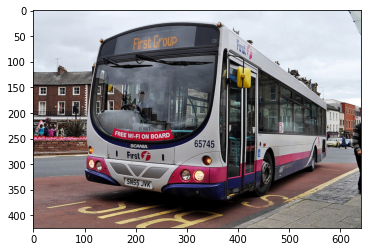

Caption:
 a double decker bus is driving down the street <unk>


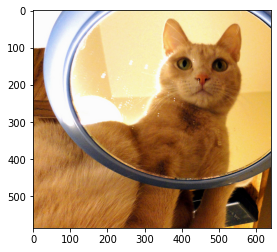

Caption:
 a cat is sitting on a bed with a book <unk>


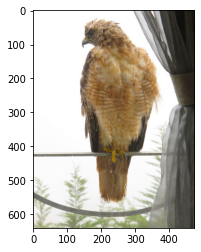

Caption:
 a bird is sitting on the ground near a tree <unk>


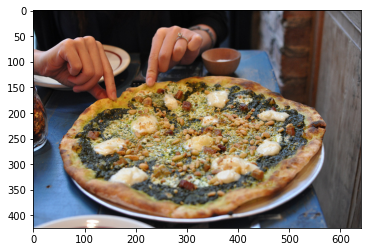

Caption:
 a close up of a pizza with a knife and a knife <unk>


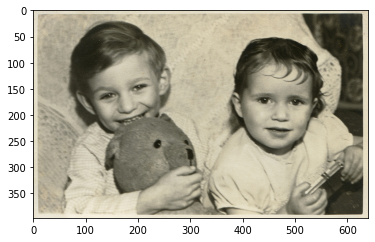

Caption:
 a man holding a remote in his hands <unk>


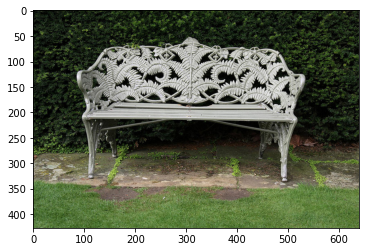

Caption:
 a large brown and white bear standing in a field <unk>


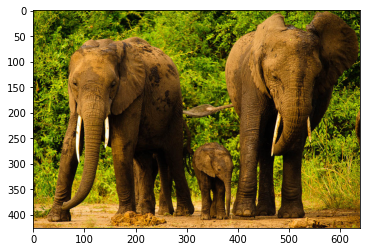

Caption:
 a group of elephants standing in a field with other animals <unk>


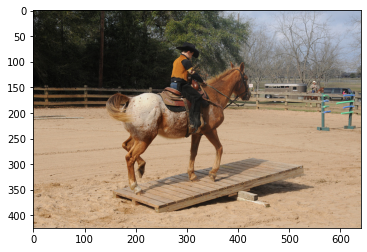

Caption:
 a woman is standing on a horse in a field <unk>


' a woman is standing on a horse in a field <unk>'

In [ ]:
valPath = '/content/drive/MyDrive/MSCOCO_2017/val2017/'

Generate_caption(valPath+"000000485480.jpg")
Generate_caption(valPath+"000000000885.jpg")
Generate_caption(valPath+"000000005037.jpg")
Generate_caption(valPath+"000000063552.jpg")
Generate_caption(valPath+"000000270705.jpg")

Generate_caption(valPath+"000000307172.jpg")
Generate_caption(valPath+"000000321333.jpg")
Generate_caption(valPath+"000000322829.jpg")
Generate_caption(valPath+"000000346905.jpg")
Generate_caption(valPath+"000000454798.jpg")


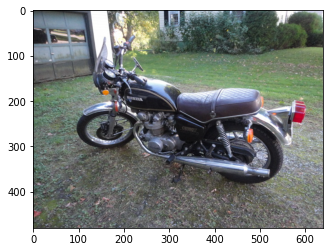

Caption:
 a motorcycle parked on the side of the road <unk>


' a motorcycle parked on the side of the road <unk>'

In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000179765.jpg')

# 評估模型準確度 Evaluate model
用來產生 BLEU, METEOR, ROUGE_L, CIDEr 分數

### 產生 validation set 的所有圖片的預測結果

In [ ]:
# 取得不重複的 val 圖片檔名列表
val_anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(val_anno_path)
val_annotation = json.load(input_file)

id_list = set()
for cap in val_annotation['annotations']:
  id_list.add(cap['image_id'])

id_list = list(id_list)

In [ ]:
len(id_list)

5000

In [ ]:
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for id in tqdm(range(2696, len(id_list))):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  complete_path = img_path + '/%012d.jpg' % id_list[id]
  cap = Generate_caption(complete_path,False)
  one_result["image_id"] = id
  one_result["caption"] = cap
  results.append(one_result)


In [ ]:
len(results)

In [ ]:
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

In [ ]:
print(list(id_list)[2695])
complete_path = img_path + '/%012d.jpg' % list(id_list)[2695]
print(complete_path)
test_image = plt.imread(complete_path)
plt.imshow(test_image)
plt.show()
# 懷疑是某狀況會預測到 argmax 會取到 0，造成後面要取 inv_word_index[0] 出錯
cap = Generate_caption(complete_path, True)
print(cap)

In [ ]:
# 產生假的完美結果，測試用

'''
added_caps = set()
results = list()
for cap in annotation['annotations']:
  if cap['image_id'] not in added_caps:
    added_caps.add(cap['image_id'])
    one_result = dict()
    one_result["image_id"] = cap["image_id"]
    one_result["caption"] = cap["caption"]
    results.append(one_result)
  
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)
'''

### coco-caption evaluation
從 GitHub 抓別人寫好的評分模組   
官方版是 tylin/coco-caption ，而 davidfsemedo 是相容 Python 3 的修改版本

In [ ]:
!git clone https://github.com/davidfsemedo/coco-caption


In [ ]:
import os, sys
sys.path.insert(0,"/content/coco-caption")

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')


In [ ]:
#  workaround provided by https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
modified_anno_path = "/content/modified_captions_val2017.json"

with open(anno_path, 'r') as f:
    data = json.load(f)
    data['type'] = 'captions'
with open(modified_anno_path, 'w') as f:
    json.dump(data, f)

In [ ]:
coco = COCO(modified_anno_path)
cocoRes = coco.loadRes(generated_caption_path)

In [ ]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

In [ ]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))